In [4]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import trompy as tp
import csv
from datetime import datetime, timedelta

metafile_path = "/workspaces/FEDPROFERENCE/FEDXD_METAFILE.xls"  # Adjusted path to the uploaded file
rows, header = tp.metafilereader(metafile_path, sheetname="METAFILE")
#pd.read_excel(metafile_path, sheet_name="METAFILE")


In [18]:
DATA_FOLDER = "/workspaces/FEDPROFERENCE/data"


def tweak_fed(df):
    return (df
             .rename(columns={"MM:DD:YYYY hh:mm:ss": "t",
                             "InterPelletInterval": "ipi"})
             .assign(t=lambda df_: pd.to_datetime(df_.t))
#              .set_index("t")
#              .query("Event == 'Pellet'")
             # .loc["2022-09-12 08:00:00":] # cuts off training phase
             .loc[:, ["t", "Event", "FR", "Device_Number", "ipi", "Poke_Time"]]
           )

df = pd.read_csv(os.path.join(DATA_FOLDER, "FED001_041723_00.CSV"))
df1 = tweak_fed(df)

df = pd.read_csv(os.path.join(DATA_FOLDER, "FED002_041723_00.CSV"))
df2 = tweak_fed(df)


# List to hold all the processed dataframes
all_dataframes = []

# Loop through all CSV files in the DATA_FOLDER
for filename in os.listdir(DATA_FOLDER):
    if filename.endswith(".CSV") or filename.endswith(".csv"):
        filepath = os.path.join(DATA_FOLDER, filename)
        try:
            df = pd.read_csv(filepath)
            modified_df = tweak_fed(df)
            all_dataframes.append(modified_df)
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

# Optional: Concatenate all dataframes into one


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)





#display all the rows and columns in the finaL_df

all_dataframes

In [9]:
df1


,t,Event,FR,Device_Number,ipi,Poke_Time
0,2023-04-17 11:18:10,Right,1,1,NaN,12.78
1,2023-04-17 11:19:11,Left,1,1,NaN,0.25
2,2023-04-17 11:21:57,Pellet,1,1,NaN,NaN
3,2023-04-17 11:22:49,Left,1,1,NaN,0.17
4,2023-04-17 11:24:01,RightWithPellet,1,1,NaN,0.17
...,...,...,...,...,...,...
442,2023-04-18 09:48:59,Right,1,1,NaN,0.84
443,2023-04-18 09:49:01,Left,1,1,NaN,0.05
444,2023-04-18 09:49:28,Pellet,1,1,81.0,NaN
445,2023-04-18 10:01:49,Left,1,1,NaN,0.02


In [11]:
def clean_fed(df):
    
    return (df
            .iloc[1:]
            .set_index("t")
           )

def sync_feds(df1, df2):
    
    offset = df2.query("Poke_Time > 5").t - df1.query("Poke_Time > 5").t
    offset = pd.Timedelta(offset.iloc[0])
    
    
    df2 = df2.assign(t=df2.t.sub(offset))
#     df1 = clean_fed(df1)
#     df2 = clean_fed(df2)
    
    return df1, df2, offset

df1, df2, offset = sync_feds(df1, df2)

print(df1.head(3))
print(df2.head(3))
df1

                    t   Event  FR  Device_Number  ipi  Poke_Time
0 2023-04-17 11:18:10   Right   1              1  NaN      12.78
1 2023-04-17 11:19:11    Left   1              1  NaN       0.25
2 2023-04-17 11:21:57  Pellet   1              1  NaN        NaN
                    t  Event  FR  Device_Number  ipi  Poke_Time
0 2023-04-17 11:18:10  Right   1              2  NaN      12.59
1 2023-04-17 11:25:28  Right   1              2  NaN       0.00
2 2023-04-17 11:26:28   Left   1              2  NaN       0.25


,t,Event,FR,Device_Number,ipi,Poke_Time
0,2023-04-17 11:18:10,Right,1,1,NaN,12.78
1,2023-04-17 11:19:11,Left,1,1,NaN,0.25
2,2023-04-17 11:21:57,Pellet,1,1,NaN,NaN
3,2023-04-17 11:22:49,Left,1,1,NaN,0.17
4,2023-04-17 11:24:01,RightWithPellet,1,1,NaN,0.17
...,...,...,...,...,...,...
442,2023-04-18 09:48:59,Right,1,1,NaN,0.84
443,2023-04-18 09:49:01,Left,1,1,NaN,0.05
444,2023-04-18 09:49:28,Pellet,1,1,81.0,NaN
445,2023-04-18 10:01:49,Left,1,1,NaN,0.02


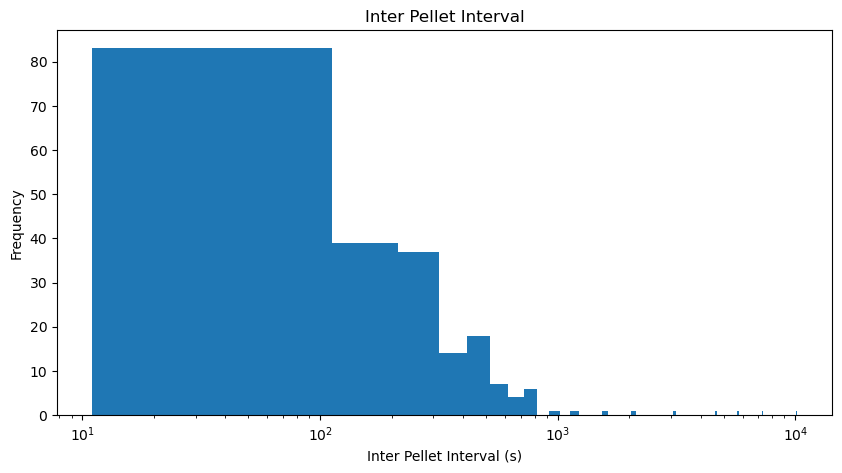

c:\Users\hta031\AppData\Local\miniconda3\envs\DATA\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


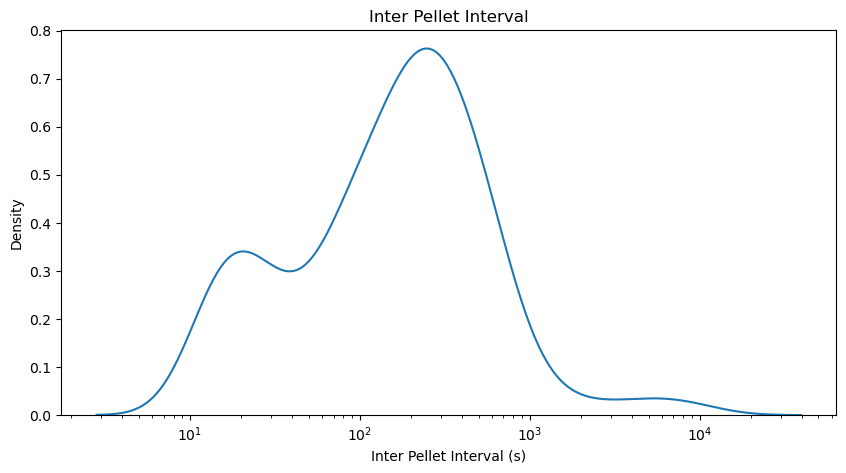

In [5]:
df= pd.concat([df1, df2], axis=0)
df
#sort by t
df = df.sort_values(by='t')
# remove the first 2 rows
df = df.iloc[2:]
df
df = df.query("Event == 'Pellet'")
df


# calculate the inter pellet interval
df['IPI'] = df.t.diff()
df['IPI'] = df['IPI'].dt.total_seconds()
# df['IPI'] = df['IPI'].shift(-1)
df

# plot histogram of IPI with log scale
plt.figure(figsize=(10, 5))

plt.hist(df['IPI'], bins=100)
plt.xscale('log')
plt.xlabel('Inter Pellet Interval (s)')
plt.ylabel('Frequency')
plt.title('Inter Pellet Interval')
plt.show()

# porbability density function
plt.figure(figsize=(10, 5))
sns.kdeplot(df['IPI'], log_scale=True)
plt.xlabel('Inter Pellet Interval (s)')
plt.ylabel('Density')
plt.title('Inter Pellet Interval')
plt.show()


In [6]:
pd.options.display.max_rows= 40000
pd.options.display.max_columns= 40000
df.reset_index(drop=True, inplace=True)

# make a new column that is whether the device number is the same or different as previuse row
df['same_device'] = df['Device_Number'] == df['Device_Number'].shift(1)
df.query("same_device == False and IPI < 60")

,t,Event,FR,Device_Number,ipi,Poke_Time,IPI,same_device
12,2023-04-17 12:05:37,Pellet,1,1,356.0,NaN,19.0,False
29,2023-04-17 12:52:39,Pellet,1,1,344.0,NaN,28.0,False
37,2023-04-17 13:20:20,Pellet,1,1,373.0,NaN,19.0,False
64,2023-04-17 18:58:54,Pellet,1,1,172.0,NaN,36.0,False
70,2023-04-17 19:11:12,Pellet,1,1,311.0,NaN,15.0,False
82,2023-04-17 20:08:10,Pellet,1,1,228.0,NaN,28.0,False
204,2023-04-18 07:10:22,Pellet,1,1,454.0,NaN,18.0,False
